Introduction:
The dataset includes histopathological images of size 96px * 96px, labeled 1 if at least one pixel in the 32 x 32 center region showed tumor tissue and 0 if no pixel showed tumor tissue. The goal is to use CNN to develop a model that can detect patterns and signs of cancer cells in an image and can accurately predict unseen data.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2

import tensorflow as tf
from keras import datasets, layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator

EDA and Data Visualization:

In [2]:
df = pd.read_csv(r'C:\histopathologic-cancer-detection\train_labels.csv')
df.fillna(0, inplace=True)

print(df.info())
print(df.head())

path = 'C:/histopathologic-cancer-detection/'

train_imgs = os.listdir(path + 'train')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


(96, 96, 3)


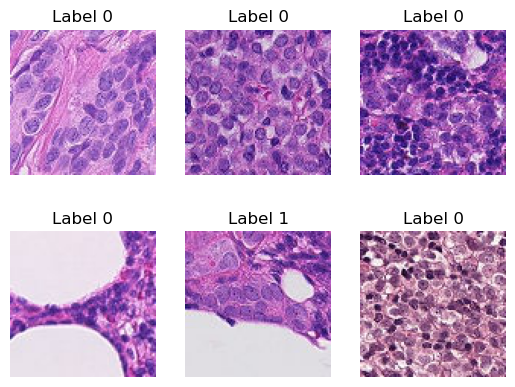

In [3]:
for i in range(6):
    rand = random.randint(0,len(df))
    image = plt.imread(path + 'train/' + train_imgs[rand])
    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Label " + str(df["label"][rand]))
    
print(np.array(image).shape)

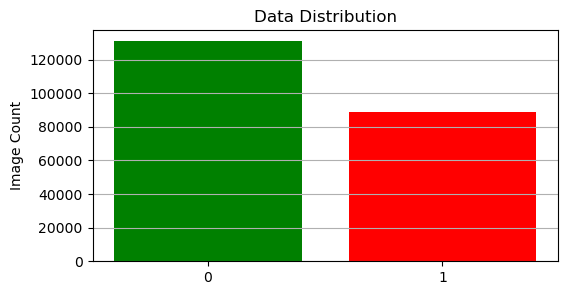

In [4]:
labels = df["label"].unique()
counts = df["label"].value_counts()

plt.figure(figsize=(6, 3))
plt.bar(labels, counts, color=["green", "red"])
plt.ylabel("Image Count")
plt.title("Data Distribution")
plt.xticks(labels)
plt.grid(axis='y')
plt.show()

Data Extraction:

In [5]:
df['id']=df['id'].apply(lambda x: x+'.tif')

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
)

train= train_datagen.flow_from_dataframe(
                dataframe= df,
                directory= path + 'train/',
                x_col = 'id',
                y_col = 'label',
                subset='training',
                target_size=(96, 96),
                batch_size=64,
                class_mode='raw',
                #preprocessing_function= read_tiff
                )

val = train_datagen.flow_from_dataframe(
                dataframe= df,
                directory= path + 'train/',
                x_col = 'id',
                y_col = 'label',
                subset='validation',
                target_size=(96, 96),
                batch_size=64,
                shuffle=False,
                class_mode='raw',
                #preprocessing_function= read_tiff
                )

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
)

test = test_datagen.flow_from_directory(path,
                                        target_size=(96, 96),
                                        batch_size=64,
                                        classes= ['test'],
                                        class_mode = 'categorical',
                                        shuffle=False)



Found 176020 validated image filenames.
Found 44005 validated image filenames.
Found 57458 images belonging to 1 classes.


Build and train CNN model:

In [6]:
model = models.Sequential()

learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.add(layers.Rescaling(1./255, input_shape=(96,96,3)))

model.add(layers.Conv2D(32, (3, 3), strides=(2,2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), strides=(2,2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), strides=(2,2), activation='relu'))


model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))


model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 47, 47, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 128)        

Epoch 1/3


2751/2751 [==============================] - 1149s 417ms/step - loss: 0.5887 - accuracy: 0.6829 - val_loss: 0.4948 - val_accuracy: 0.7744
Epoch 2/3
2751/2751 [==============================] - 1211s 440ms/step - loss: 0.4915 - accuracy: 0.7771 - val_loss: 0.4807 - val_accuracy: 0.7841
Epoch 3/3
2751/2751 [==============================] - 1068s 388ms/step - loss: 0.4838 - accuracy: 0.7802 - val_loss: 0.4735 - val_accuracy: 0.7859


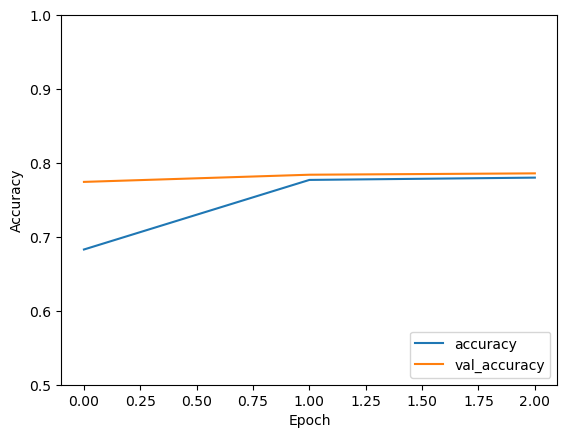

In [7]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


history = model.fit(train, epochs=3, validation_data=val, batch_size=128)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

Prediction and Submission:

In [8]:
test_img = os.listdir(path + 'test')
test_img = sorted(test_img)

pred = model.predict(test)

898/898 [==============================] - 384s 428ms/step


In [9]:
model_pred = pd.DataFrame(columns=['id', 'label'])
model_pred['id'] = [filename.split('.')[0] for filename in test_img]
model_pred['label'] = np.round(pred.flatten()).astype('int')

model_pred.to_csv('submission.csv', index=False)

Github repository URL: 